In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score,
                           roc_curve, precision_recall_curve,
                           confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [1]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.

In [4]:
borda_features = pd.read_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection/borda_ranks_Male_50-70.csv", index_col=0)

In [5]:
borda_features.head()

,BL,V02,V04,V06,V08
Gene,,,,,
ENSG00000000005.5,5048.0,3685.0,NaN,NaN,NaN
ENSG00000000419.12,NaN,NaN,12619.0,NaN,NaN
ENSG00000000457.13,1260.0,NaN,6236.0,14091.0,NaN
ENSG00000000460.16,15683.0,9179.0,NaN,NaN,NaN
ENSG00000000938.12,13428.0,NaN,NaN,NaN,NaN


In [6]:
greatest_rank = borda_features[['BL', 'V02', 'V04', 'V06', 'V08']].max().max()
lowest_rank = borda_features[['BL', 'V02', 'V04', 'V06', 'V08']].min().min()

print("Greatest value:", greatest_rank)
print("Lowest value:", lowest_rank)

Greatest value: 16788.0
Lowest value: 1.0


In [7]:
features_detected_in_all_visits = borda_features.dropna(how='any')
features_detected_in_all_visits

,BL,V02,V04,V06,V08
Gene,,,,,
ENSG00000069206.15,7939.0,12960.0,11172.0,7259.0,13285.0
ENSG00000102010.14,31.0,10476.0,920.0,10837.0,10051.0
ENSG00000106018.13,11228.0,1346.0,99.0,6350.0,8020.0
ENSG00000111052.7,5148.0,10236.0,14323.0,7280.0,3844.0
ENSG00000114416.17,16325.0,11290.0,4002.0,13349.0,7919.0
...,...,...,...,...,...
ENSG00000280232.1,15636.0,5342.0,12237.0,8249.0,6275.0
ENSG00000281741.2,9.0,1987.0,222.0,7156.0,2526.0
ENSG00000283537.2,4486.0,1457.0,157.0,881.0,503.0


In [8]:
bl_non_nan_values = borda_features['BL'].dropna().sort_values(ascending=False)
bl_non_nan_values

Gene
ENSG00000243005.3     16788.0
ENSG00000238049.2     16787.0
ENSG00000229666.1     16786.0
ENSG00000179965.11    16785.0
ENSG00000261757.1     16784.0
                       ...   
ENSG00000199241.1         5.0
ENSG00000221571.3         4.0
ENSG00000181381.13        3.0
ENSG00000207208.1         2.0
ENSG00000217083.1         1.0
Name: BL, Length: 16788, dtype: float64

In [9]:
top_bl_non_nan_values = bl_non_nan_values[bl_non_nan_values > 10000]

In [10]:
mask = ((ppmi_ad.obs['Age_Group'] == '50-70') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [11]:
ppmi_ad = ppmi_ad[mask]

In [12]:
ppmi_ad = ppmi_ad[:, ppmi_ad.var.index.isin(top_bl_non_nan_values.index)]

In [13]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [15]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr__C': np.logspace(-3, 3, 7),
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear'],
    'smote__k_neighbors': [3, 5]
}

grid_search = GridSearchCV(
    lr_pipeline,
    param_grid,
    cv=StratifiedKFold(10),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [17]:
best_lr.named_steps['lr'].get_params()

{'C': np.float64(1000.0),
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [18]:
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:,1]

In [19]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.31      0.38        16
           1       0.72      0.85      0.78        34

    accuracy                           0.68        50
   macro avg       0.61      0.58      0.58        50
weighted avg       0.65      0.68      0.66        50



In [20]:
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.3f}")


ROC-AUC: 0.697
PR-AUC: 0.829


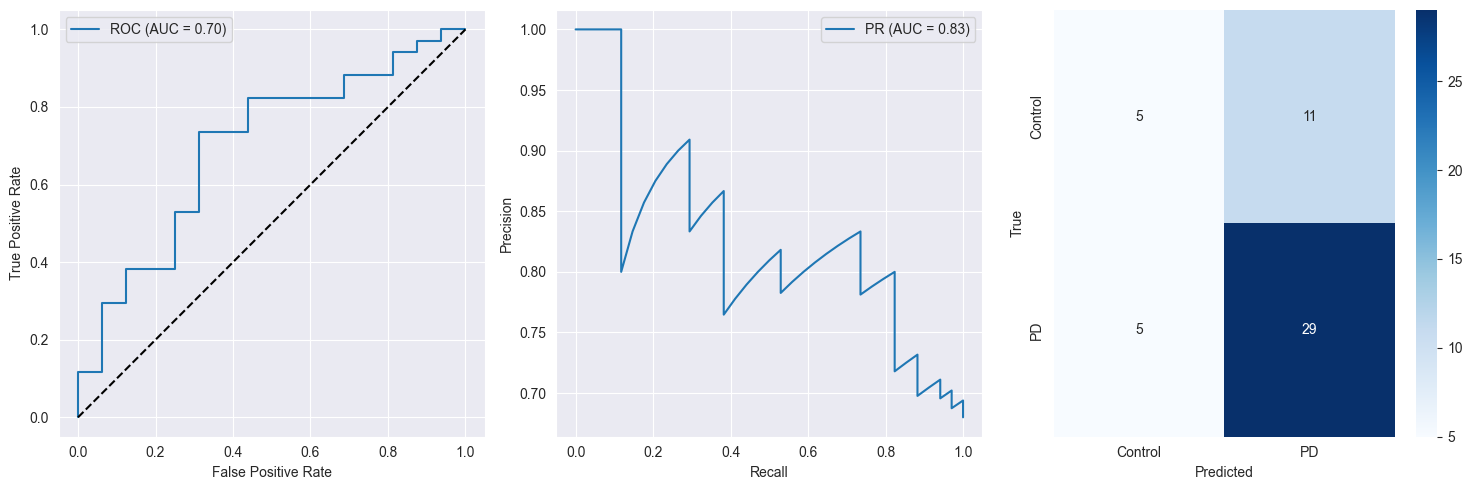

In [21]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, roc_threshold = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y_test, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [22]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = {'roc_auc': [], 'pr_auc': []}

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lr_pipeline.fit(X_train, y_train)
    y_proba = lr_pipeline.predict_proba(X_val)[:, 1]

    cv_scores['roc_auc'].append(roc_auc_score(y_val, y_proba))
    cv_scores['pr_auc'].append(average_precision_score(y_val, y_proba))

print("\nCross-validation results:")
print(f"ROC-AUC: {np.mean(cv_scores['roc_auc']):.3f} ± {np.std(cv_scores['roc_auc']):.3f}")
print(f"PR-AUC: {np.mean(cv_scores['pr_auc']):.3f} ± {np.std(cv_scores['pr_auc']):.3f}")



Cross-validation results:
ROC-AUC: 0.722 ± 0.110
PR-AUC: 0.854 ± 0.060
